# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas  https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: Xi Han, Haoran Zhao

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import display


<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. We will also use Principal Components Analysis (PCA) to reduce its dimensions. 



<div class='exercise'><b> Question 1 [25 pts]: Data Exploration </b></div>

First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

**1.1** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

**1.2** Notice that the resulting training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?  Explain in 3 or fewer sentences.

**1.3** Let's explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

**1.4** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors and different markers ('x' vs 'o', for example). How well do the top two principal components discriminate between the two classes? How much of the variance within the predictor set do these two principal components explain? 

**1.5** Plot the cumulative variance explained in the feature set as a function of the number of PCA-components (up to the first 50 components).  Do you feel 2 components is enough, and if not, how many components would you choose to consider?  Justify your choice in 3 or fewer sentences.  Finally, determine how many components are needed to explain at least 90% of the variability in the feature set. 

#### Answers:
First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [3]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**1.1:** Take a peek at your training set...

In [4]:
print(data_train.shape)
print(data_test.shape)

(40, 7130)
(33, 7130)


In [5]:
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
2,0,-106,-125,-76,168,-230,-284,4,-122,70,...,156,649,57,504,-26,250,314,14,56,-25
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
9,0,-476,-213,-18,301,-403,-394,-42,-144,98,...,241,1214,127,255,50,1701,1108,61,525,-83
10,0,-81,-150,-119,78,-152,-340,-36,-141,96,...,186,573,-57,694,-19,636,205,17,127,-13


In [6]:
data_train.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.37500,-116.125000,-163.350000,-9.125000,209.075000,-250.325000,-379.925000,-118.775000,-195.42500,82.850000,...,185.175000,641.250000,-14.800000,419.175000,-31.400000,818.875000,283.850000,11.425000,491.450000,-32.750000
std,0.49029,102.783364,95.437871,101.998539,111.000205,107.218776,123.026449,304.307494,100.91654,99.683743,...,87.141173,305.573085,92.745088,394.131039,54.429818,458.186178,197.123227,36.221461,653.148075,37.159221
min,0.00000,-476.000000,-531.000000,-168.000000,-24.000000,-496.000000,-696.000000,-1038.000000,-452.00000,-148.000000,...,42.000000,91.000000,-295.000000,-24.000000,-220.000000,67.000000,-42.000000,-100.000000,-33.000000,-108.000000
25%,0.00000,-140.750000,-208.500000,-81.250000,124.250000,-316.500000,-461.750000,-269.250000,-238.50000,-0.250000,...,133.750000,424.500000,-57.250000,241.750000,-57.250000,540.000000,189.000000,-8.250000,151.000000,-62.750000
50%,0.00000,-109.000000,-150.000000,-29.000000,228.000000,-225.000000,-384.500000,-77.000000,-172.00000,99.000000,...,179.500000,619.000000,10.500000,343.000000,-21.000000,747.000000,282.000000,10.000000,242.000000,-30.500000
75%,1.00000,-64.750000,-99.500000,47.000000,303.750000,-178.750000,-286.250000,20.500000,-125.75000,164.500000,...,227.000000,728.000000,52.250000,475.750000,11.250000,1042.500000,351.750000,28.250000,536.000000,-12.750000
max,1.00000,86.000000,-20.000000,262.000000,431.000000,-32.000000,-122.000000,367.000000,-11.00000,283.000000,...,413.000000,1655.000000,132.000000,2527.000000,50.000000,2313.000000,1108.000000,81.000000,3192.000000,78.000000


In [7]:
# your code here
def normalize_columns(X, X_min, X_max):
    return (X-X_min)/(X_max-X_min)

X_min = np.min(data_train,axis=0)
X_max = np.max(data_train,axis=0)
data_train = normalize_columns(X=data_train, X_min=X_min, X_max=X_max)
data_test = normalize_columns(X=data_test, X_min=X_min, X_max=X_max)   

In [8]:
data_train.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.37500,0.640347,0.719472,0.369477,0.512253,0.529472,0.550653,0.654253,0.581803,0.535615,...,0.385916,0.351822,0.656206,0.173726,0.698519,0.334762,0.283348,0.615608,0.162620,0.404570
std,0.49029,0.182889,0.186767,0.237206,0.243956,0.231075,0.214332,0.216589,0.228836,0.231285,...,0.234882,0.195379,0.217202,0.154501,0.201592,0.204001,0.171412,0.200119,0.202527,0.199781
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.596530,0.631115,0.201744,0.325824,0.386853,0.408101,0.547153,0.484127,0.342807,...,0.247305,0.213235,0.556792,0.104175,0.602778,0.210597,0.200870,0.506906,0.057054,0.243280
50%,0.00000,0.653025,0.745597,0.323256,0.553846,0.584052,0.542683,0.683986,0.634921,0.573086,...,0.370620,0.337596,0.715457,0.143865,0.737037,0.302760,0.281739,0.607735,0.085271,0.416667
75%,1.00000,0.731762,0.844423,0.500000,0.720330,0.683728,0.713850,0.753381,0.739796,0.725058,...,0.498652,0.407289,0.813232,0.195904,0.856481,0.434328,0.342391,0.708564,0.176434,0.512097
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
data_test.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,...,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.303030,0.641055,0.733737,0.371388,0.409524,0.512409,0.479516,0.744937,0.606473,0.533502,...,0.328188,0.387352,0.664112,0.141442,0.679686,0.297215,0.322661,0.597355,0.120583,0.429456
std,0.466694,0.165245,0.189658,0.335398,0.239065,0.298177,0.309424,0.174231,0.222876,0.187403,...,0.271523,0.194909,0.193956,0.138439,0.180964,0.194876,0.186667,0.296720,0.179463,0.233766
min,0.000000,0.112100,0.174168,-0.562791,-0.026374,-0.096983,-0.198606,0.489680,-0.024943,0.153132,...,-0.269542,0.021739,0.257611,0.014504,0.266667,0.029386,0.035652,-0.591160,-0.010853,-0.440860
25%,0.000000,0.560498,0.618395,0.255814,0.232967,0.312500,0.240418,0.620641,0.519274,0.406032,...,0.164420,0.268542,0.578454,0.076833,0.551852,0.203028,0.184348,0.508287,0.046202,0.349462
50%,0.000000,0.683274,0.767123,0.374419,0.373626,0.566810,0.496516,0.716726,0.625850,0.494200,...,0.239892,0.350384,0.662763,0.103489,0.677778,0.269368,0.322609,0.607735,0.074729,0.451613
75%,1.000000,0.749110,0.872798,0.504651,0.558242,0.698276,0.736934,0.839146,0.752834,0.635731,...,0.463612,0.475703,0.768150,0.163073,0.796296,0.330365,0.423478,0.751381,0.090853,0.575269
max,1.000000,0.873665,1.013699,1.116279,0.923077,1.314655,0.954704,1.243416,0.970522,0.928074,...,0.846361,0.872123,1.201405,0.769502,1.007407,0.838379,0.824348,1.187845,0.791628,0.795699


**1.2:** Notice that the resulting training set contains...

*your answer here*

With more predictors than observations, 
* the model is underdetermined with a sparse coefficient vector, containing a few non-zero elements, the remaining elements zero. 
* We risk finding spurious relationships between predictors and response.

**1.3:** Let's explore a few of the genes...

Text(0.5,1,'AFFX-PheX-5_at')

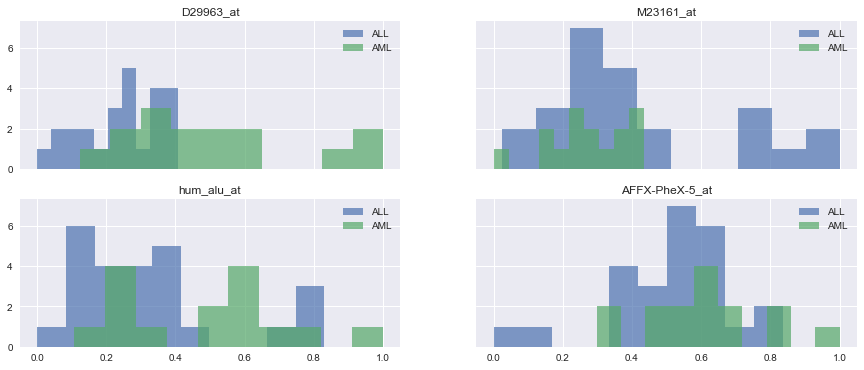

In [10]:
# your code here
gene_list = ["D29963_at", "M23161_at", "hum_alu_at", "AFFX-PheX-5_at"]
f, axarr = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)

axarr[0,0].hist(data_train.loc[data_train['Cancer_type'] == 0, 'D29963_at'], label= 'ALL', alpha = 0.7)
axarr[0,0].hist(data_train.loc[data_train['Cancer_type'] == 1, 'D29963_at'], label= 'AML', alpha = 0.7)
axarr[0,0].legend()
axarr[0,0].set_title('D29963_at')

axarr[0,1].hist(data_train.loc[data_train['Cancer_type'] == 0, 'M23161_at'], label= 'ALL', alpha = 0.7)
axarr[0,1].hist(data_train.loc[data_train['Cancer_type'] == 1, 'M23161_at'], label= 'AML', alpha = 0.7)
axarr[0,1].legend()
axarr[0,1].set_title('M23161_at')

axarr[1,0].hist(data_train.loc[data_train['Cancer_type'] == 0, 'hum_alu_at'], label= 'ALL', alpha = 0.7)
axarr[1,0].hist(data_train.loc[data_train['Cancer_type'] == 1, 'hum_alu_at'], label= 'AML', alpha = 0.7)
axarr[1,0].legend()
axarr[1,0].set_title('hum_alu_at')

axarr[1,1].hist(data_train.loc[data_train['Cancer_type'] == 0, 'AFFX-PheX-5_at'], label= 'ALL', alpha = 0.7)
axarr[1,1].hist(data_train.loc[data_train['Cancer_type'] == 1, 'AFFX-PheX-5_at'], label= 'AML', alpha = 0.7)
axarr[1,1].legend()
axarr[1,1].set_title('AFFX-PheX-5_at')


*your answer here*

Positive value of D29963_at and hum_alu_at is more likely to be in the AML class. Positive value of M23161_at is more likely to be in the ALL class. Negative value of AFFX-PheX-5_at is more likely to be in the ALL calss.

**1.4:** Since our data has dimensions that are not easily visualizable...

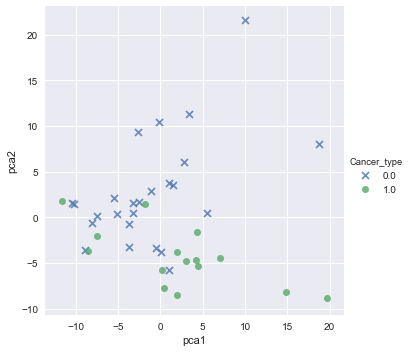

In [11]:
# your code here
x_train, y_train = data_train.iloc[:,1:], data_train.iloc[:,0]
x_test, y_test = data_test.iloc[:,1:], data_test.iloc[:,0]

pca = PCA(n_components=2)
train_pca = pd.DataFrame(pca.fit_transform(x_train), columns=['pca1','pca2'])
train_pca['Cancer_type'] = y_train.values

sns.lmplot(data = train_pca, x='pca1', y = 'pca2', hue ='Cancer_type', markers=["x", "o"], fit_reg=False)

In [13]:
print('Total variance explained:', sum(pca.explained_variance_ratio_))  

Total variance explained: 0.2731782945208866


*your answer here*

The first two components can explain about 27% of the total variance. There is some useful information in the above plot in terms of creating a classifier, however, it's difficult to draw a decision boundary that perfectly separates ALL from AML points.

**1.5**: Plot the cumulative variance explained in the feature set...

Text(0,0.5,'Total Variance Explained')

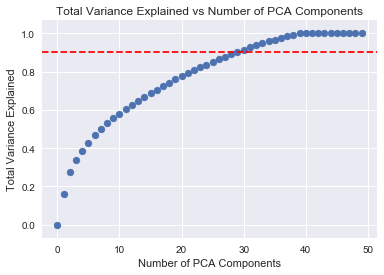

In [14]:
# your code here
df = pd.DataFrame()

for i in range(50):
    pca = PCA(n_components=i)
    pca.fit(x_train)
    df = df.append(pd.DataFrame({'dim': [i] , 'variance': [sum(pca.explained_variance_ratio_)]}))
    
plt.scatter(x=df['dim'], y=df['variance'])
plt.axhline(0.9, ls='--', color='red')
plt.title("Total Variance Explained vs Number of PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Total Variance Explained")

In [15]:
df.head()

,dim,variance
0,0,0.000000
0,1,0.158890
0,2,0.273178
0,3,0.339141
0,4,0.387005


In [16]:
temp = 1
for index, row in df.iterrows():
    if temp and row['variance'] >= 0.8:
        pca_80 = int(row['dim'])
        print("%i dimensions can explain %.1f%% of the total variance." % (pca_80, row['variance'] * 100))
        temp = 0
        
    if row['variance'] >= 0.9:
        pca_90 = int(row['dim'])
        print("%i dimensions can explain %.1f%% of the total variance." % (pca_90, row['variance'] * 100))
        break

22 dimensions can explain 80.8% of the total variance.
29 dimensions can explain 90.3% of the total variance.


*your answer here*

Two components are not enough, since they can only explain about 27% of the total variance. I would choose 22 top componenets, so that they can explain more than 80% of the total variance. 

29 dimensions are needed to explain at least 90% of the variability in the feature set.

<div class='exercise'> <b> Question 2 [25 pts]: Linear Regression vs. Logistic Regression </b> </div>

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor `D29963_at` to predict cancer type and plot the histogram of predicted values. We could interpret the scores predicted by the regression model for a patient as an estimate of the probability that the patient has `Cancer_type`=1 (AML). Is there a problem with this interpretation?

**2.2** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary classes 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy of the obtained classification model on both the training and test sets.

**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? If there are no substantial differences, why do you think this happens? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').  

**2.4** Create a figure with 4 items displayed on the same plot:
- the quantitative response from the linear regression model as a function of the gene predictor `D29963_at`.
- the predicted probabilities of the logistic regression model as a function of the gene predictor `D29963_at`.  
- the true binary response for the test set points for both models in the same plot. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 




#### Answers: 

**2.1:** Fit a simple linear regression model to the training set

In [17]:
# your code here
ols = OLS(y_train, sm.add_constant(x_train[["D29963_at"]])).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Cancer_type   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     18.61
Date:                Wed, 24 Oct 2018   Prob (F-statistic):           0.000110
Time:                        18:43:01   Log-Likelihood:                -19.769
No. Observations:                  40   AIC:                             43.54
Df Residuals:                      38   BIC:                             46.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0587      0.119     -0.492      0.625      -0.300       0.183
D29963_at      1.2764      0.296      4.314      0.000       0.677       1.875
==============================================================================
Omnibus:                        5.833   Durbin-Watson:                   0.838
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.011
Skew:                           0.775   Prob(JB):                       0.0816
Kurtosis:                       2.222   Cond. No.                         5.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*your answer here*

OLS model may have predictions outside [0,1], which are not valid probabilities.

**2.2:** The fitted linear regression model can be converted to a classification model...

In [18]:
# your code here
y_train_ols = ols.predict(sm.add_constant(x_train[["D29963_at"]]))
y_test_ols = ols.predict(sm.add_constant(x_test[["D29963_at"]]))

print("OLS prediction accuracy score in train: %0.3f" % accuracy_score(y_train, y_train_ols>0.5))
print("OLS prediction accuracy score in test: %0.3f" % accuracy_score(y_test, y_test_ols>0.5))

OLS prediction accuracy score in train: 0.800
OLS prediction accuracy score in test: 0.758


**2.3:** Next, fit a simple logistic regression model to the training set...

In [19]:
# your code here
logit = LogisticRegression(C=100000).fit(x_train[['D29963_at']], y_train)

print("Logistic Regression prediction accuracy score in train: %0.3f" % logit.score(x_train[['D29963_at']], y_train))
print("Logistic Regression prediction accuracy score in test: %0.3f" % logit.score(x_test[['D29963_at']], y_test))

Logistic Regression prediction accuracy score in train: 0.800
Logistic Regression prediction accuracy score in test: 0.758


*your answer here*

The accuracies in OLS and Logistic regressions are exactly the same. It seems that D29963_at is a powerful feature that seperates AML and ALL points reasonably well, which makes linear regression and logistic regression about equally good. 


**2.4:** Create a figure with 4 items ...

Text(0.5,0,'D29963_at')

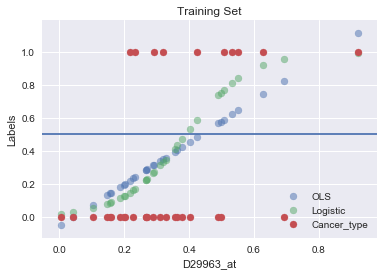

In [20]:
# your code here
plt.scatter(x_test[["D29963_at"]], y_test_ols, label="OLS", alpha=0.5)
plt.scatter(x_test[["D29963_at"]], logit.predict_proba(x_test[["D29963_at"]])[:,1], label="Logistic", alpha=0.5)
plt.scatter(x_test[["D29963_at"]], y_test, label="Cancer_type")
plt.axhline(y=0.5)
plt.legend()
plt.title("Training Set")
plt.ylabel("Labels")
plt.xlabel("D29963_at")

*your answer here*

The overall performance is similar but OLS has the prediction outside of [0, 1], which makes logistic regression better.


<div class='exercise'> <b> Question 3 [30pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

**3.3** Use the `visualize_prob` function provided below (or any other visualization) to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

**3.4** Open question: Comment on the classification accuracy of the train and test sets. Given the results above how would you assess the generalization capacity of your trained model?  What other tests or approaches would you suggest to better guard against the false sense of security on the accuracy of the model as a whole. 


In [21]:
# --------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for x
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0')

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

#### Answers:

**3.1:** Next, fit a multiple logistic regression model with all the gene predictors...

In [22]:
# your code here
logit_multi = LogisticRegression(C=100000).fit(x_train, y_train)

print("Logistic Regression with all predictors prediction accuracy score in train: %0.3f" % logit_multi.score(x_train, y_train))
print("Logistic Regression with all predictors prediction accuracy score in test: %0.3f" % logit_multi.score(x_test, y_test))


Logistic Regression with all predictors prediction accuracy score in train: 1.000
Logistic Regression with all predictors prediction accuracy score in test: 1.000


*your answer here*

Accuracy in both training (1.00) and test (1.00) improves considerably with all genes vs a single gene.

**3.2:** How many of the coefficients estimated by this multiple logistic regression...

In [23]:
b_genes = logit_multi.coef_[0]
print(b_genes.shape)
print(x_train.shape)

(7129,)
(40, 7129)


In [24]:
# Bootstrapping with 1000 boostrap samples
iterations = 1000

b_genes_boot = np.zeros((x_train.shape[1], iterations))

for i in range(iterations):
    # sample with replacement from x_train
    boot_rows = np.random.choice(range(x_train.shape[0]), size=x_train.shape[0], replace=True)    
    X_train_boot = x_train.values[boot_rows]
    y_train_boot = y_train.values[boot_rows]

    # fit
    logit_multi_boot = LogisticRegression(C=100000).fit(X_train_boot, y_train_boot)
    b_genes_boot[:,i] = logit_multi_boot.coef_


In [25]:
# Confidence Intervals
b_genes_ci_upper = np.percentile(b_genes_boot, 97.5, axis=1)
b_genes_ci_lower = np.percentile(b_genes_boot, 2.5, axis=1)

sig_b = 0

# if CI contains 0, then insignificant
for i in range(x_train.shape[1]):
    if b_genes_ci_upper[i] < 0 or b_genes_ci_lower[i] > 0:
        sig_b += 1

print("Significant coefficents at 5 precentage level: %i out of %i features." % (sig_b, x_train.shape[1]))

Significant coefficents at 5 precentage level: 1898 out of 7129 features.


*your answer here*

1898 out of 7129 features are significant at 5% significant level.

**3.3:** Use the visualize_prob function provided below ...

Text(0.5,1,'Test Set')

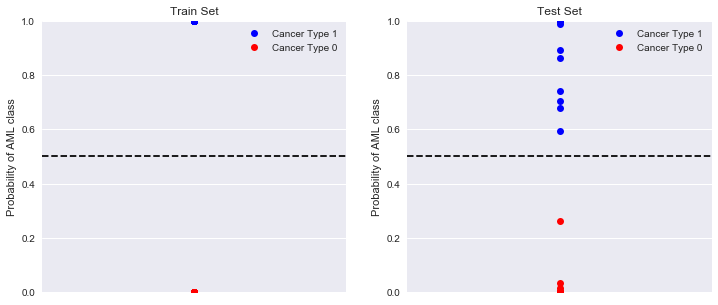

In [26]:
""" Plot classification model """
# your code here
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
visualize_prob(
    model=logit_multi,
    x=x_train,
    y=y_train,
    ax=ax1
)
ax1.set_title("Train Set")

visualize_prob(
    model=logit_multi,
    x=x_test,
    y=y_test,
    ax=ax2
)
ax2.set_title("Test Set")


*your answer here*

- Yes, there is a difference in the spread of probabilities in the training and test plots.
- In training set, the probabilities are either 1 or 0. In test set, several predicted probabilities fall closer to 0.5.
- For these points close to 0.5, we are unsure if we should predict it as 0 or 1.

**3.4:** Open question: Comment on the classification accuracy...


*your answer here* 

The classification accuracies on the train and test sets are both 100%, however, there are too many features that are not statistically significant in the logistic regression model. To assess the generailization capacity of the trained model, we should test it on more unseen data. We could also use cross-valication to guard against the false sense of security on the accuracy of the model.

<div class='exercise'><b> Question 4 [20 pts]: PCR: Principal Components Regression </b></div>

High dimensional problems can lead to problematic behavior in model estimation (and make prediction on a test set worse), thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

**4.1:** Fit two separate Logistic Regression models using principal components as the predictors: (1) with the number of components you selected from problem 1.5 and (2) with the number of components that explain at least 90% of the variability in the feature set. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3?   

**4.2:** Use the code provided in question 3 (or your choice of visualization) to visualize the probabilities predicted by the fitted models in the previous part on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?


#### Answers:

**4.1:** Fit two separate Logistic Regression models...

In [27]:
# your code here
print("The number of compoennts that explain at least 80%% of total variance: %i" % pca_80)
print("The number of compoennts that explain at least 90%% of total variance: %i" % pca_90)

The number of compoennts that explain at least 80% of total variance: 22
The number of compoennts that explain at least 90% of total variance: 29


In [28]:
x_train_pca_80 = pca.transform(x_train)[:, :pca_80]
x_test_pca_80 = pca.transform(x_test)[:, :pca_80]

logit_pca_80 = LogisticRegression(C=100000).fit(x_train_pca_80, y_train)

print("Logistic Regression with 22 PCA components prediction accuracy score in train: %0.3f" % logit_pca_80.score(x_train_pca_80, y_train))
print("Logistic Regression with 22 PCA components prediction accuracy score in test: %0.3f" % logit_pca_80.score(x_test_pca_80, y_test))

Logistic Regression with 22 PCA components prediction accuracy score in train: 1.000
Logistic Regression with 22 PCA components prediction accuracy score in test: 0.909


In [29]:
x_train_pca_90 = pca.transform(x_train)[:, :pca_90]
x_test_pca_90 = pca.transform(x_test)[:, :pca_90]

logit_pca_90 = LogisticRegression(C=100000).fit(x_train_pca_90, y_train)

print("Logistic Regression with 29 PCA components prediction accuracy score in train: %0.3f" % logit_pca_90.score(x_train_pca_90, y_train))
print("Logistic Regression with 29 PCA components prediction accuracy score in test: %0.3f" % logit_pca_90.score(x_test_pca_90, y_test))

Logistic Regression with 29 PCA components prediction accuracy score in train: 1.000
Logistic Regression with 29 PCA components prediction accuracy score in test: 0.970


*your answer here*

- All three logistic regression models have 100% classification accuracies in training set. 
- The model with all features has the highest classification accuray in test set of 100%, followed by the model with 29 PCA components of 97%, and finally the model with 22 PCA components (the model I chose) of 91%. 

**4.2:** Use the code provided in question 3...

Text(0.5,0.98,'Logistic model with PCA components that can explain >80% total varaibility')

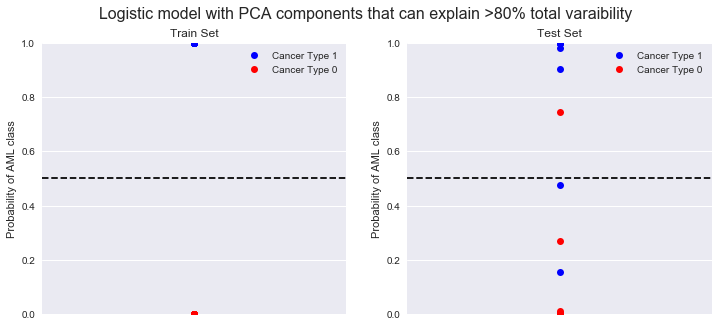

In [30]:
# your code here
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
visualize_prob(
    model=logit_pca_80,
    x=x_train_pca_80,
    y=y_train,
    ax=ax1
)
ax1.set_title("Train Set")

visualize_prob(
    model=logit_pca_80,
    x=x_test_pca_80,
    y=y_test,
    ax=ax2
)
ax2.set_title("Test Set")
f.suptitle('Logistic model with PCA components that can explain >80% total varaibility', fontsize=16)

Text(0.5,0.98,'Logistic model with PCA components that can explain >90% total varaibility')

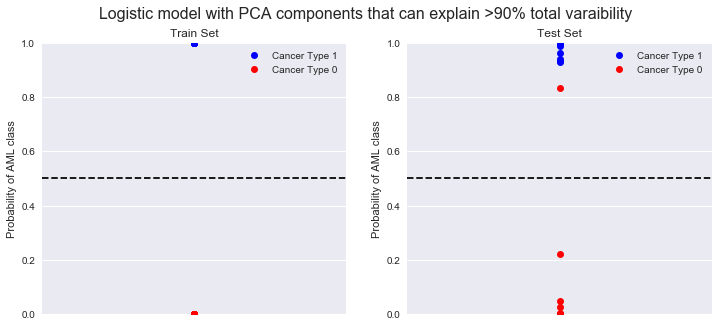

In [31]:
# your code here
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
visualize_prob(
    model=logit_pca_90,
    x=x_train_pca_90,
    y=y_train,
    ax=ax1
)
ax1.set_title("Train Set")

visualize_prob(
    model=logit_pca_90,
    x=x_test_pca_90,
    y=y_test,
    ax=ax2
)
ax2.set_title("Test Set")
f.suptitle('Logistic model with PCA components that can explain >90% total varaibility', fontsize=16)

*your answer here*

- In training set, all three models have 100% classification accuray. 
- In test set, the logistic model with PCA components yields comparable predictive power, even though there are several points are misclassified. 
- We risk finding spurious relationships between predictors and response with the logistic model with all predictors.
- With PCA, we hope to find some lower dimensional representation of our predictors that can retain predictive power and hopefully less vulnerable to overfitting.
